In [1]:
%matplotlib inline

import wget
import h5py

# fname = wget.download('https://sandbox.zenodo.org/record/1027635/files/mnist.hdf5?download=1')
fname = 'mnist.hdf5'
f = h5py.File(fname)

In [2]:
import dask.array as da
import numpy as np
from dask_ml.model_selection import train_test_split

X = da.from_array(f['training-images'][0:20000], chunks=1000)
y = da.from_array(f['training-labels'][0:20000], chunks=1000)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=0)

# X_test = da.from_array(f['training-images'][10000:20000], chunks=1000)
# y_test = da.from_array(f['training-labels'][10000:20000], chunks=1000)

# X = da.from_array(f['test-images'], chunks=1000)
# y = da.from_array(f['test-labels'], chunks=1000)

In [3]:
X_train

dask.array<concatenate, shape=(10000, 784), dtype=uint8, chunksize=(500, 784), chunktype=numpy.ndarray>

In [4]:
from dask.distributed import Client, progress
from joblib import parallel_backend

client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='4GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.192.2:8787/status,
Dashboard: http://192.168.192.2:8787/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://192.168.192.2/17724/1,Workers: 1
Dashboard: http://192.168.192.2:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: inproc://192.168.192.2/17724/4,Total threads: 4
Dashboard: http://192.168.192.2:42827/status,Memory: 3.73 GiB
Nanny: None,


In [5]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

with parallel_backend('dask'):

    clf = RandomForestClassifier()

    clf.fit(X_train, y_train)

    yhat_test['RandomForest'] = clf.predict(X_test)

print((yhat_test['RandomForest'] == y_test).mean().compute())

import pandas as pd
grp_test = pd.Series(yhat_test['RandomForest'].astype('str'), dtype='category')

0.9467


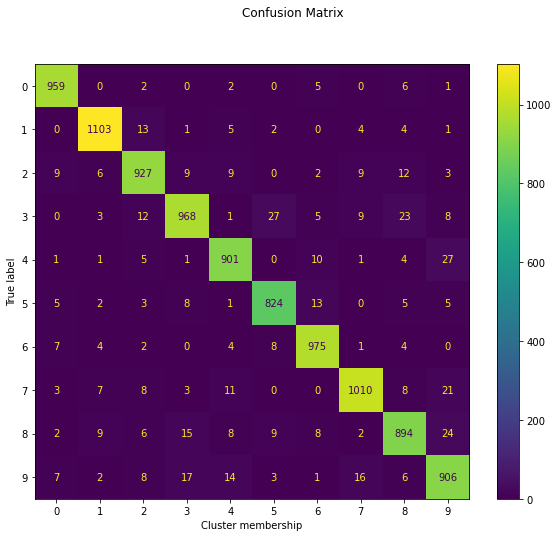

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test.astype('str'), grp_test)
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))
disp.ax_.set_xlabel('Cluster membership');

In [7]:
param_grid = clf.get_params()
# param_grid.update({
#     # 'max_features': ['sqrt', 'log2'],
#     'n_estimators': [100, 200],
#     'min_samples_leaf': [1, 3]
# })
param_grid

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [8]:
from dask_ml.model_selection import GridSearchCV

from sklearn.svm import SVC
estimator = SVC(gamma='auto', random_state=0, probability=True)
param_grid = {
    'C': [0.001, 10.0],
    'kernel': ['rbf', 'poly'],
}

from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=200, min_samples_split=3)
param_grid = {
    'min_samples_leaf': [1, 3, 5]
}

from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
estimator = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [2, 3, 4],
    'weights': ['uniform', 'distance'],
}
# param_grid = {}

grid_search = GridSearchCV(estimator,
                param_grid=param_grid,
                return_train_score=False,
                cv=3)

# with parallel_backend('dask'):
# with parallel_backend('dask', scatter=[X_train, y_train]):

grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_.get_params())

yhat_test = grid_search.best_estimator_.predict(X_test)

print((yhat_test == y_test).mean().compute())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.9543


In [6]:
import pandas as pd
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.190221,0.503070,1.453431,0.049686,True,8,2,4,8,50,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.820036,0.842484,0.825983,0.829501,0.009496,32
1,16.065313,0.175703,1.605564,0.081918,True,8,2,4,8,100,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.843431,0.864686,0.842784,0.850301,0.010176,23
2,8.686454,0.281036,1.502438,0.149789,True,8,2,4,10,50,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.830834,0.853285,0.830783,0.838301,0.010596,29
3,15.855504,0.022555,1.693100,0.098319,True,8,2,4,10,100,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.843731,0.864686,0.842184,0.850201,0.010262,24
4,8.816383,0.198037,1.370730,0.195908,True,8,2,5,8,50,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.830534,0.842184,0.830783,0.834500,0.005434,31


In [9]:
from dask_ml.cluster import KMeans
clf = KMeans(init='k-means++', n_clusters=10, init_max_iter=4, random_state=0)
%time clf.fit(X_train)
clf.labels_
clf.labels_[:10].compute()

CPU times: user 1min 2s, sys: 54.4 s, total: 1min 56s
Wall time: 22.3 s


array([0, 0, 4, 4, 8, 2, 2, 8, 7, 3], dtype=int32)

In [ ]:
def plot_digits(X_, y_, num_figs, y_caption='True label'):

    from matplotlib.pyplot import figure
    from numpy import ceil

    num_rows = ceil(num_figs/5).astype(int)

    fig = figure(figsize=(20, 4.8*num_rows))

    for j, ((i, img), (i, lab)) in enumerate(zip(X_.iterrows(), y_.iteritems())):

        tf = fig.add_subplot(num_rows, 5, j+1)
        tf.matshow(img.values.reshape((28, -1)), cmap='gray')
        tf.set_title('%s: %s\n' % (y_caption, lab), fontsize = 20)

        if j+1 == num_figs: break

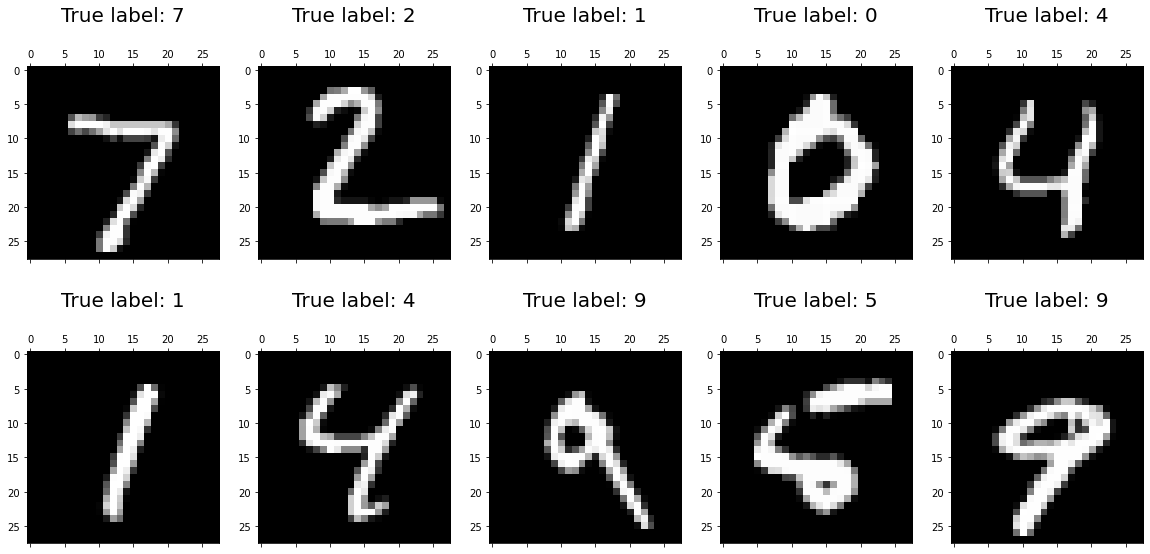

In [ ]:
plot_digits(X_train, y_train, 10)

In [14]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

# module loading
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

yhat_test['RandomForest'] = clf.predict(X_test)

print((yhat_test['RandomForest'] == y_test).mean().compute())

0.9483


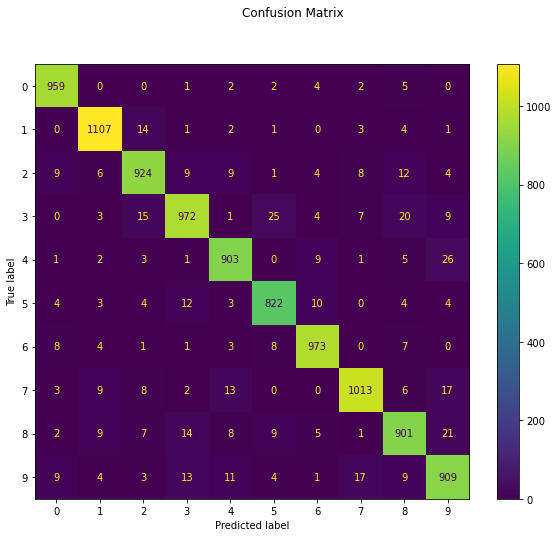

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat_test['RandomForest'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8));

In [ ]:
import numpy as np

cluster_label = dict()
for one in np.unique(grp_test):
    majority = y_test[(grp_test==one).values].value_counts()
    print('Majority of points in cluster', one, 'have label', majority.idxmax())
    cluster_label[str(one)] = majority.idxmax()

Majority of points in cluster 0 have label 1
Majority of points in cluster 1 have label 1
Majority of points in cluster 2 have label 3
Majority of points in cluster 3 have label 0
Majority of points in cluster 4 have label 7
Majority of points in cluster 5 have label 2
Majority of points in cluster 6 have label 6
Majority of points in cluster 7 have label 4
Majority of points in cluster 8 have label 4
Majority of points in cluster 9 have label 8


In [ ]:
def subset_images(data, true_labels, cluster_assignment, digit, cluster):

    cond = (cluster_assignment == cluster).values & (true_labels == digit).values

    return data[cond], true_labels[cond], cluster_assignment[cond]


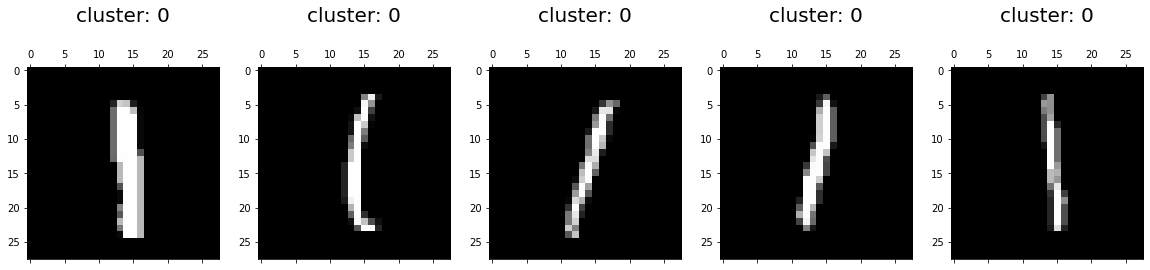

In [ ]:
# upright
d, l, c = subset_images(X_test, y_test, grp_test, '1', '0')
plot_digits(d, c, 5, 'cluster')

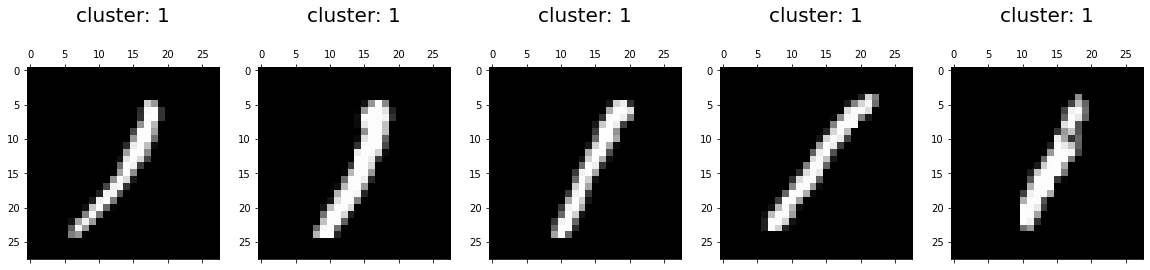

In [ ]:
# slanted
d, l, c = subset_images(X_test, y_test, grp_test, '1', '1')
plot_digits(d, c, 5, 'cluster')

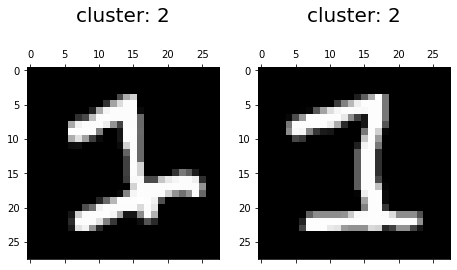

In [ ]:
# fancy
d, l, c = subset_images(X_test, y_test, grp_test, '1', '2')
plot_digits(d, c, 5, 'cluster')

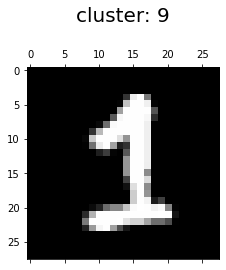

In [ ]:
# fancy upright
d, l, c = subset_images(X_test, y_test, grp_test, '1', '9')
plot_digits(d, c, 5, 'cluster')